In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [2]:
recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (14585287, 3)


,app_id,is_recommended,user_id
2307118,1145360,True,2597309
1889941,1846380,True,4457610
7378728,1000360,True,1152924
7939199,262060,False,6207094
11381505,1657630,False,6372672


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 81.74532747268677 seconds


In [4]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [5]:
del item_data
del titles

Epoch 0/Training error: 0.693146556845577/Validation error: 0.6931471141864457/Time: 39.96 seconds
Epoch 1/Training error: 0.6931457066087556/Validation error: 0.6931470605643569/Time: 38.86 seconds
Epoch 2/Training error: 0.6931434645017457/Validation error: 0.6931462799458873/Time: 39.23 seconds
Epoch 3/Training error: 0.6931314059432736/Validation error: 0.6931381130025313/Time: 38.56 seconds
Epoch 4/Training error: 0.6930328631171677/Validation error: 0.6930574503937146/Time: 40.53 seconds
Epoch 5/Training error: 0.6921197453045622/Validation error: 0.6922830154596815/Time: 39.08 seconds
Epoch 6/Training error: 0.6848264751670771/Validation error: 0.6860701062254828/Time: 42.03 seconds
Epoch 7/Training error: 0.6580638995510144/Validation error: 0.663697231844792/Time: 38.83 seconds
Epoch 8/Training error: 0.6155972281828272/Validation error: 0.6299667639469022/Time: 38.94 seconds
Epoch 9/Training error: 0.5707301999887753/Validation error: 0.5969388594294277/Time: 39.31 seconds
Ep

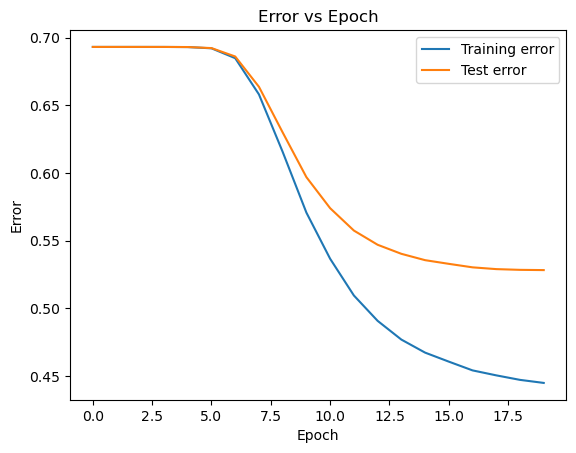

Test rmse 0.4207061188285936


In [56]:
EPOCHS = 20

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, 
    learning_rate=0.2, C=0.1)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [7]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump(svd_predictor, file)
print("Done saving model.")

Saving model...
Done saving model.


In [32]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training error: 0.6921694337959329/Validation error: 0.6923298850251494/Time: 39.68 seconds
Epoch 1/Training error: 0.6913365065906782/Validation error: 0.6916198490390773/Time: 39.24 seconds
Epoch 2/Training error: 0.6898517254205297/Validation error: 0.6903519653725709/Time: 39.37 seconds
Epoch 3/Training error: 0.6873363716149801/Validation error: 0.6882042433304206/Time: 39.23 seconds
Epoch 4/Training error: 0.6833900867526994/Validation error: 0.6848480327877141/Time: 39.37 seconds
Epoch 5/Training error: 0.6775672989695416/Validation error: 0.6799234010824523/Time: 39.93 seconds
Epoch 6/Training error: 0.6696470849826658/Validation error: 0.6732692778899099/Time: 41.19 seconds
Epoch 7/Training error: 0.659937970799354/Validation error: 0.6652194151449676/Time: 39.56 seconds
Epoch 8/Training error: 0.6485311038657168/Validation error: 0.6558899569490058/Time: 39.15 seconds
Epoch 9/Training error: 0.6365281368623434/Validation error: 0.6462366921437354/Time: 39.72 seconds


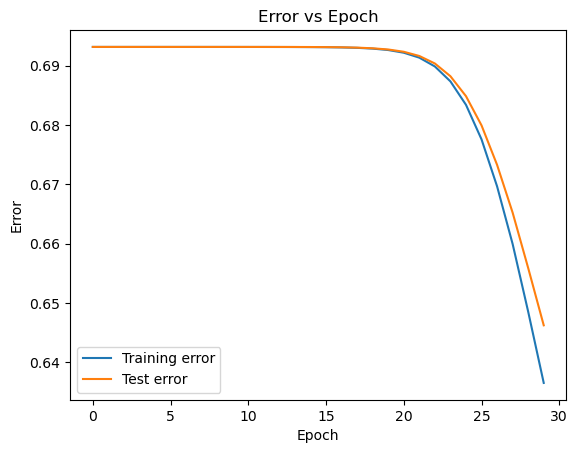

Test rmse 0.47658209944043256


In [33]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [70]:
j = 12
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.7160129806465397, 'CarX Drift Racing Online'),
 (0.7159511585014864, 'The Sekimeiya: Spun Glass'),
 (0.7132553431625946, 'Football Manager 2023'),
 (0.7123257362764844, 'Counter-Strike: Global Offensive'),
 (0.712154838354979, 'Zork Anthology'),
 (0.7121127369801797, 'Fences 4'),
 (0.711929434244226, 'House Flipper'),
 (0.7116595404739016, 'The Deal'),
 (0.7115713283055459, 'Rust'),
 (0.7114195190539436, 'My Singing Monsters'),
 (0.7114126380750102, 'The Test'),
 (0.7112605136278495, 'ShellShock Live'),
 (0.7111222382047517, 'When The Night Comes'),
 (0.7110315421344838, 'Contradiction: Spot The Liar'),
 (0.7105944982416522, 'Keep Talking and Nobody Explodes'),
 (0.7104243424331131, 'Monster Prom 2: Monster Camp'),
 (0.7104041571464756, 'Terraria'),
 (0.7103216175678654, 'Hollow Knight'),
 (0.7101637253541936, 'ELDEN RING'),
 (0.7100427499751693,
  'Demon Slayer -Kimetsu no Yaiba- The Hinokami Chronicles')]
True top n:
['DayZ']


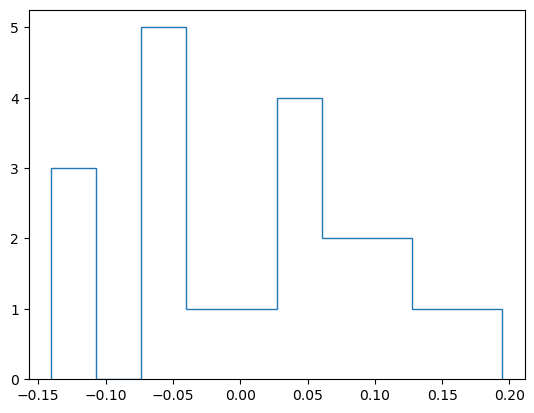

In [54]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [15]:
rec_data.search_title('mortal')

[('Noel the Mortal Fate S1-7', 2177),
 ('Mortal Kombat X', 1045),
 ('IMMORTALITY', 803),
 ('Mortal Shell', 775),
 ('鬼谷八荒 Tale of Immortal', 1936),
 ('Dark Deception: Monsters & Mortals', 856),
 ('Mortal Online 2', 1241),
 ('Mortal Kombat\xa011', 773)]

In [16]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'NARAKA: BLADEPOINT', 1),
 (229, 'Highrise City', 1),
 (966, 'Steel Division 2', 0)]


In [17]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

ZeroDivisionError: division by zero

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])